# Potter vs Star Wars - Classification of hummed and whistled star wars and harry potter theme into 'StarWars' and 'Potter'

In [75]:
#import all useful libraries used in this notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa
import librosa.display

from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# 1 Author

**Name**:  Achal Mittal



# 2 Problem formulation

The problem that will be attempted in this notebook is of identifying a user recorded hum or whistle as one of two songs using machine learning. The focus will be on solving a binary classification problem to identify either the Harry Potter theme ('Potter') or the Star Wars theme ('StarWars'), given a recording of a hum or a whistle as an input. 

While small in scale, this is still an interesting problem as the process can be used as a test bed for: <br>
a. identifying and extracting useful features that define the 'essence' of a song, and <br>    
b. find suitable machine learning models that can be trained to produce a high accuracy classifier. 

The learnings derived can hopefully then be scaled to a multi-class problem with multiple songs(not in the scope of this notebook).

# 3 Machine Learning pipeline

It is important to define the term 'pipeline' as it is used differently by different people in machine learning context. A 'pipeline' in the context of the problem defined above is defined as a sequence of instructions that will allow an input (user recorded hum or whistle) to be classified into either a 'Potter' theme or a 'StarWars' theme. The pipeline is what will be deployed (not in scope of this project) in the real world as part of an app or any other tool for users to use, and contains the features and the models that have been selected after rigorous experimentation and evaluation. The process for finalising the pipeline is discussed in Section 6 - Methodology.

The machine learning pipeline that has been recommended for implementation in this notebook is shown as a flowchart below:

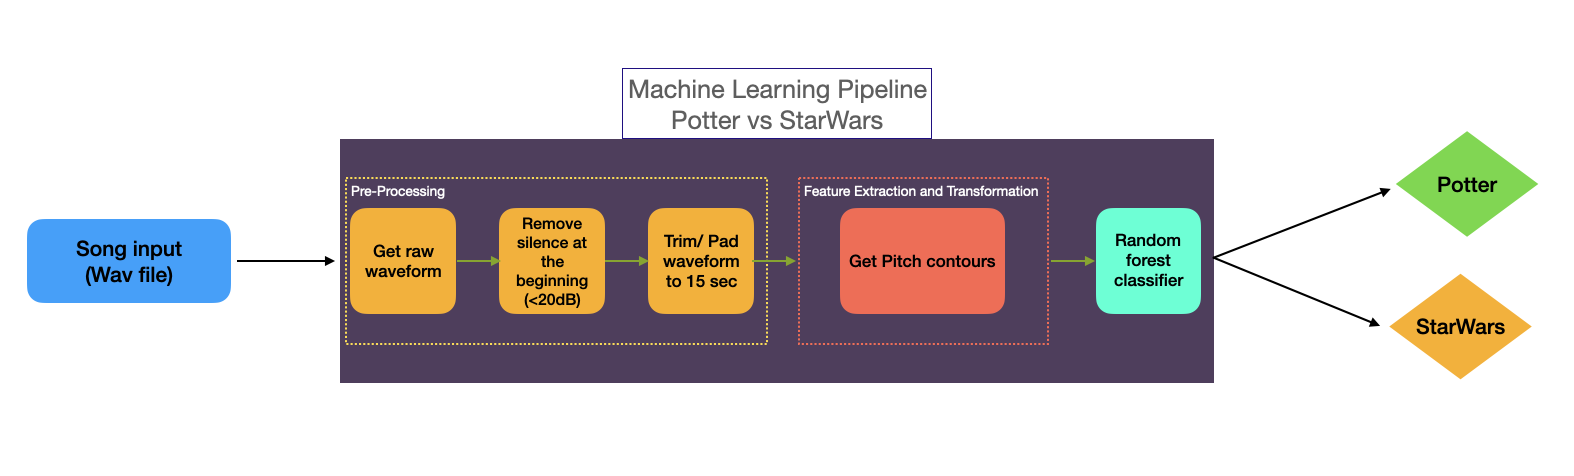

In [72]:
#display pipeline
display(Image(filename = "/Users/achalmittal/Desktop/Github repositories/QMUL_DSAI/ECS7020P - Principles of Machine Learning/Mini Project/Pipeline_Potter_wars_v2.png"))

Going through the steps shown above in order and giving a brief description:

- `Song input` - The input should be a .wav file, containing a recording of humming or whistling of a song by a user. 
- `Pre-processing`:
    - `Get raw waveform` - The .wav file is read in and the raw waveform (sampled at 44.1kHz) is saved as a numpy array.
    - `Remove silence at the beginning` - Silence has been defined as any sound less than 20dB in this solution. The function implemented finds the first instance (sample) in a waveform that is over 20dB and saves the input waveform starting at this point. The reason for this step is because the silence at the start of a recording does not provide any useful information. In addition, it helps in aligning the starting point of a song which helps in gaining useful and important information from the extracted features (that are time based - discussed below).
    - `Trim/Pad waveform` - Once the first non-silent sample is found in the recording, the next 15 seconds are saved. The waveform data is either trimmed to 15 sec or padded to 15 sec with zeros if the length of the recording is not long enough.
- `Feature Extraction/ Transformation`:
    - `Pitch contour extraction` - The features used in the pipeline are called pitch contours. They are discussed in more detail in Section 4 - Transformation stage. In terms of the data transformation, the trimmed waves from the previous step are split into frames based on a frame size and a hop length. In each frame, the fundamental frequency (f0) of the frame is found and saved. The resulting array (which can be considered a transformed compression - it is of a much smaller length than the input) consists of the fundamental frequency for each frame. This vector will be the input to the model with the f0 values per frame being the features.
- `Classification using Random Forest` - Finally, the transformed data is fed into the classifier that has been chosen for the pipeline (discussed in detail in Sections 5 and 6) and will predict a label for the song.

# 4 Transformation stage

This section will discuss the features used in the pipeline, and any associated transformations. It is important to note that rigorous workflow and experimentation (discussed in Section 6 - Methodology) led to the selection of the features (pitch contours) that will be discussed in this section. Other features that were explored and experimented with can be found in the appendix (Section 10).

Pitch contours define how the the fundamental frequency changes over time. A visualisation is shown in Section 7 - Dataset. Pitch contours, theoretically, capture the high level melodic content as perceived by humans in an audio signal, and would therefore be suitable for the task of distinguishing one song from another.

The input is a waveform sampled at 44.1kHz and trimmed to 15 sec with no silence at the start of the recording (reasons discussed above). The pitch contours are extracted from the trimmed waveform using [librosa's pyin function](https://librosa.org/doc/main/generated/librosa.pyin.html) that estimates the fundamental frequency for every frame analysed within the input signal. The frame length in the pipeline has been defined as 8192 which equates to 186 ms of audio per frame. The hop length (how much to shift after each frame has been analysed) has been defined as half the frame length. This results in 50% overlap between frames (it's important to make the signals stationary). For 44100 samples per second in a 15 sec input, the number of fundamental frequencies that will be captured will equate to around 162. These are the no. of features that will be used. 

Thus, the input was a raw waveform of 661500 (15 sec * 44100 samples/sec) amplitude values and the output is a series of 162 fundamental frequencies (one per frame analysed).

The pitch contours can have 'Nan' values after extraction and hence the 'Nan' values are replaced with zeros. This is the final output that is fed into the model.

# 5 Modelling

It is intuitive to think that any ML model for this problem will need to be able to assess the similarity between the fundamental frequencies for a given frame for different inputs to determine a label. Thus, classifiers such as kNN (distance based similarity), and Random Forest (using features to determine useful information gain) were obvious choices for experimentation. The models were evaluated against each other using test data (see Section 6 and Section 8) and Random Forest was deemed to be the better algorithm for the pipeline.

With the dataset used in this problem, and the features that are input into the model, the classifier is able to find features (fundamental frequency per frame) where maximum useful information (using the gini index) can be gained to predict the label of the song correctly.

# 6 Methodology

The below shows the workflow that was applied on this project which led to the final pipeline that has been recommended/ implemented in this notebook:

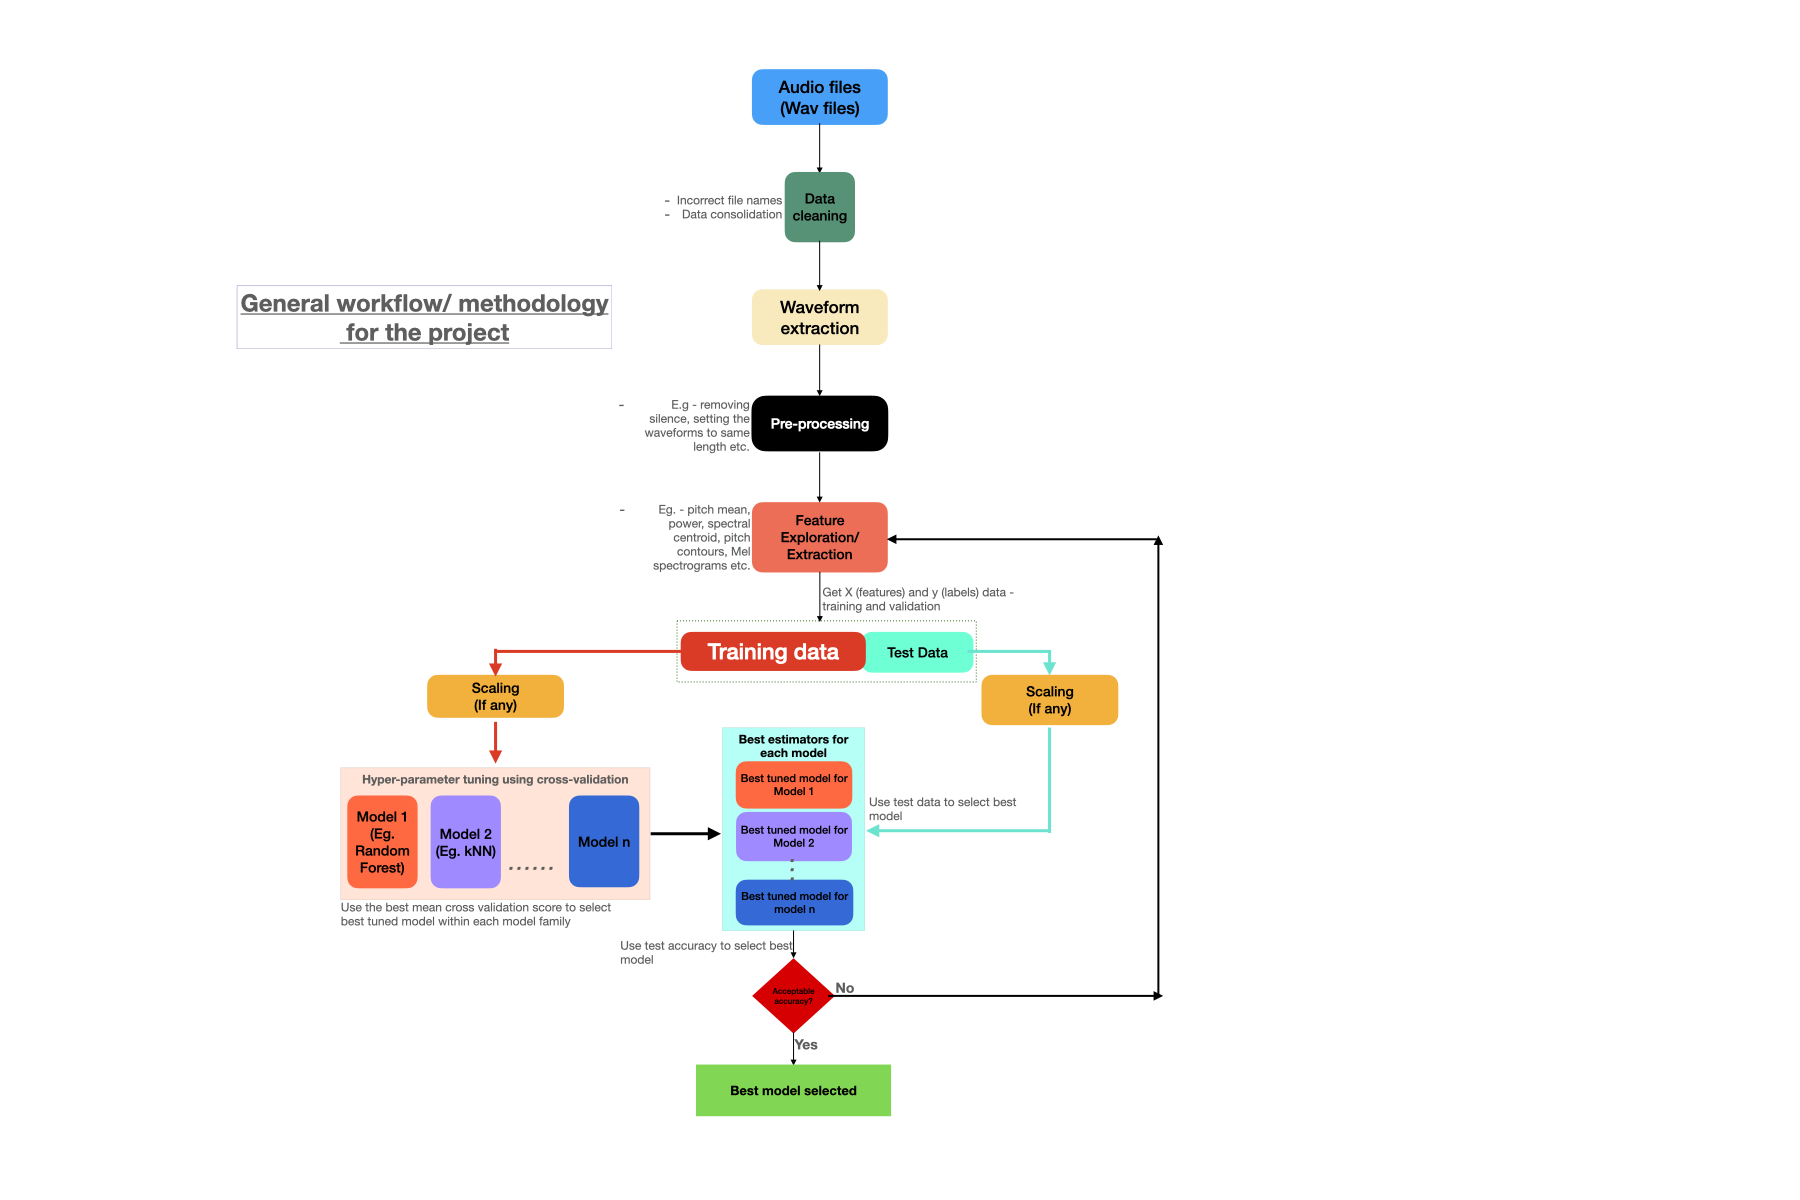

In [76]:
#display workflow/ methodology

display(Image(filename="/Users/achalmittal/Desktop/Github repositories/QMUL_DSAI/ECS7020P - Principles of Machine Learning/Mini Project/workflow_002.png"))

A few important points to note from the above (the rest should be self-explanatory from the diagram):

- `Pre-processing` - Tasks such as silence removal and trimming were carried out for all the data. As mentioned before, this was to get as much useful data as possible from the waveforms in the feature extraction stage. In addition, the trimming ensured that all samples were of equal length. This was an important consideration as each feature vector in the input X array needed to be of the same size. Most of the features that were experimented with were properties of the audio signal in a given frame within the signal.
- Multiple different models (algorithms) were evaluated. The hyperparameters for each algorithm were tuned using a [randomised search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) or [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) k-fold cross validation. Training data (see diagram above) was used for this purpose. The mean cross validation score was used to select the best tuned model. The best tuned model for each algorithm were then compared against one another by using the test accuracy obtained from using the test data. The algorithms that were used included Random Forest, and kNN (k-nearest neighbors). Other models (such as logistic regression and naive bayes) were used during initial experimentation but were discarded soon after due to poor performance/ unsuitability.
- `Feature exploration/ extraction` -  This was the most crucial part of the process. Understanding what separates the 'essence' of one song from another, and extracting that useful information was crucial to get a high accuracy pipeline. Features would either be evaluated visually (where possible - see section 10.1.5), or through the accuracies obtained by the machine learning models, or both. If the accuracy was not acceptable, more research was carried out to find new features and then the process was repeated. Some of the features that were evaluated include pitch mean, power, mel spectograms, spectral centroids, onset strength, and pitch contours.
- Experiments with and without scaling were performed and non-scaled data performed better and hence scaling is not part of the pipeline but part of the workflow.
- The final model with the final features were then selected for the pipeline.

# 7 Dataset

The MLEnd Hums and Whistles public dataset v0 was used for this project. Specifically:

- `Potter`
    - Part 1: https://collect.qmul.ac.uk/down?t=6122TDAA73VPCMDQ/5DSHD27BLQMK5S8E1HLG19O
    - Part 2: https://collect.qmul.ac.uk/down?t=4LV64IN5OK5E35NN/4H6DJTRS7KVD704UG2CN0IG

- `StarWars`
    - Part 1: https://collect.qmul.ac.uk/down?t=650T7K3FAE26MB29/592IN2FALUM43SGC35O0580
    - Part 2: https://collect.qmul.ac.uk/down?t=6L5DHHRODAMK82R8/4512VDDUEFGBAPK0S82ENGO

In this section, pre-processing of the full dataset (all parts) will be carried out, the features to be used will be extracted, and the dataset will be separated into 'training' (used for hyperparameter tuning using cross validation), and 'test' data (for final model selection). For conciseness and simplicity, not all experiments/ iterations (as discussed in the previous section) will be included here, only some interesting ones (see Section 10 - Appendix for other features that were explored). 

## 7.1 Data loading, cleaning, and pre-processing

<b> Note that the all the code in this notebook uses paths local to the machine of the author and hence will be unrunnable. Outputs (where necessary) have been included. </b>

In [6]:
#get directory of songs and save paths
os.chdir('/Users/achalmittal/Downloads')
path = os.getcwd()
starwars_path_2 = path + '/StarWars_2/*'
potter_path_2 = path + '/Potter_2/*'
starwars_path_1 = path + '/StarWars_1/*'
potter_path_1 = path + '/Potter_1/*'
path_list = [potter_path_1,potter_path_2,starwars_path_1,starwars_path_2]

In [7]:
#helper functions to clean/rename original files
def clean_file_names(path, song):
    """In path (string), find files that don't conform to the format: [StudentID]_[interpretation]_[interpretation number]_[song]
    and rename them to this format. Returns list of all corrected files with their index in the original list.
    Ensure song input is in the correct format eg. StarWars or Potter"""
    file_paths = glob.glob(path)
    file_names = [file.split('/')[-1] for file in file_paths]
    wrong_files = [[i,file_names[i]] for i in range(len(file_names)) if not re.fullmatch('^[S][0-9]+_(hum|whistle)_[0-9]_'+ song +'.wav',file_names[i])]
    corrected_files = []
    for item in wrong_files:
        item[1] = item[1].replace(" ", "").replace("[", "").replace("]","").upper() #remove spaces, brackets, and convert eveything to uppercase
        s_id = item[1].split('_',1)[0] #get student id
        rest = item[1].split('_',1)[1] #get rest of string
        int_num = re.search('[0-9]',rest).group() #get the interpretation number from the rest of the string
        if 'HUM' in rest: #assumption that no one has spelt 'hum' wrong in their original submission
            corrected_files.append([item[0], s_id+'_hum_'+int_num+'_'+song+'.wav'])
        else:
            corrected_files.append([item[0], s_id+'_whistle_'+int_num+'_'+song+'.wav'])
    
    return corrected_files

def rename_files(path,list_of_filenames):
    """Path is the directory where all the files reside. Ensure path ends in '/*' to find all the files. 
    list_of_filenames is a list of lists. Each sublist consists of index of the original file and the new file name."""
    file_paths = glob.glob(path) #get original file paths
    file_names = [file.split('/')[-1] for file in file_paths] #get original filenames
    [os.rename(path.rstrip('*') + file_names[f[0]], path.rstrip('*') + f[1]) for f in list_of_filenames] 
    return None

#only need to run the below once to clean file names and rename in directory
# for song_path in path_list:
#     corrected_files = clean_file_names(song_path,song_path.split('/')[-2].split('_')[0])
#     rename_files(song_path, corrected_files)

In [8]:
#get all files - should be clean by this stage

files_potter = glob.glob(potter_path_1) + glob.glob(potter_path_2)
files_starwars = glob.glob(starwars_path_1) + glob.glob(starwars_path_2)
potter_wars_list = files_potter + files_starwars
potter_wars_table = [] 

for file in potter_wars_list:
  location = file.rpartition('/')[0] + file.rpartition('/')[1]
  file_name = file.rpartition('/')[-1]
  participant_ID = file.split('/')[-1].split('_')[0]
  interpretation_type = file.split('/')[-1].split('_')[1]
  interpretation_number = file.split('/')[-1].split('_')[2]
  song = file.split('/')[-1].split('_')[3].split('.')[0]
  potter_wars_table.append([location, file_name,participant_ID,interpretation_type,interpretation_number, song])

potter_wars_df = pd.DataFrame(potter_wars_table,columns=['location','file_id','participant','interpretation','number','song']).set_index('file_id') 
display(potter_wars_df)

,location,participant,interpretation,number,song
file_id,,,,,
S54_hum_2_Potter.wav,/Users/achalmittal/Downloads/Potter_1/,S54,hum,2,Potter
S36_hum_1_Potter.wav,/Users/achalmittal/Downloads/Potter_1/,S36,hum,1,Potter
S77_whistle_2_Potter.wav,/Users/achalmittal/Downloads/Potter_1/,S77,whistle,2,Potter
S53_hum_1_Potter.wav,/Users/achalmittal/Downloads/Potter_1/,S53,hum,1,Potter
S31_hum_2_Potter.wav,/Users/achalmittal/Downloads/Potter_1/,S31,hum,2,Potter
...,...,...,...,...,...
S190_hum_2_StarWars.wav,/Users/achalmittal/Downloads/StarWars_2/,S190,hum,2,StarWars
S164_hum_1_StarWars.wav,/Users/achalmittal/Downloads/StarWars_2/,S164,hum,1,StarWars
S135_hum_2_StarWars.wav,/Users/achalmittal/Downloads/StarWars_2/,S135,hum,2,StarWars


As seen above, the data filenames have been cleaned, and loaded. Next, pre-processing (get waveforms, remove silence, and trim/pad the signals) will be carried out:

In [17]:
# carry out the pre-processing - get waveforms

#get waveform data and time data
def get_waveforms(file_path_list,sr = 44100):
    waveforms = []
    for i in file_path_list:
        # Sampling frequency - None uses native sampling rate -44100 in our case. If not none, librosa resamples to defined value
        x, sr = librosa.load(i,sr=sr)
        waveforms.append(x)
    return waveforms, sr 
waveforms, sr = get_waveforms(potter_wars_list) #get all waveforms for potter and starwars

Getting random samples from the dataset (3 hums and 3 whistles for Potter and StarWars each) and displaying the waveforms below:

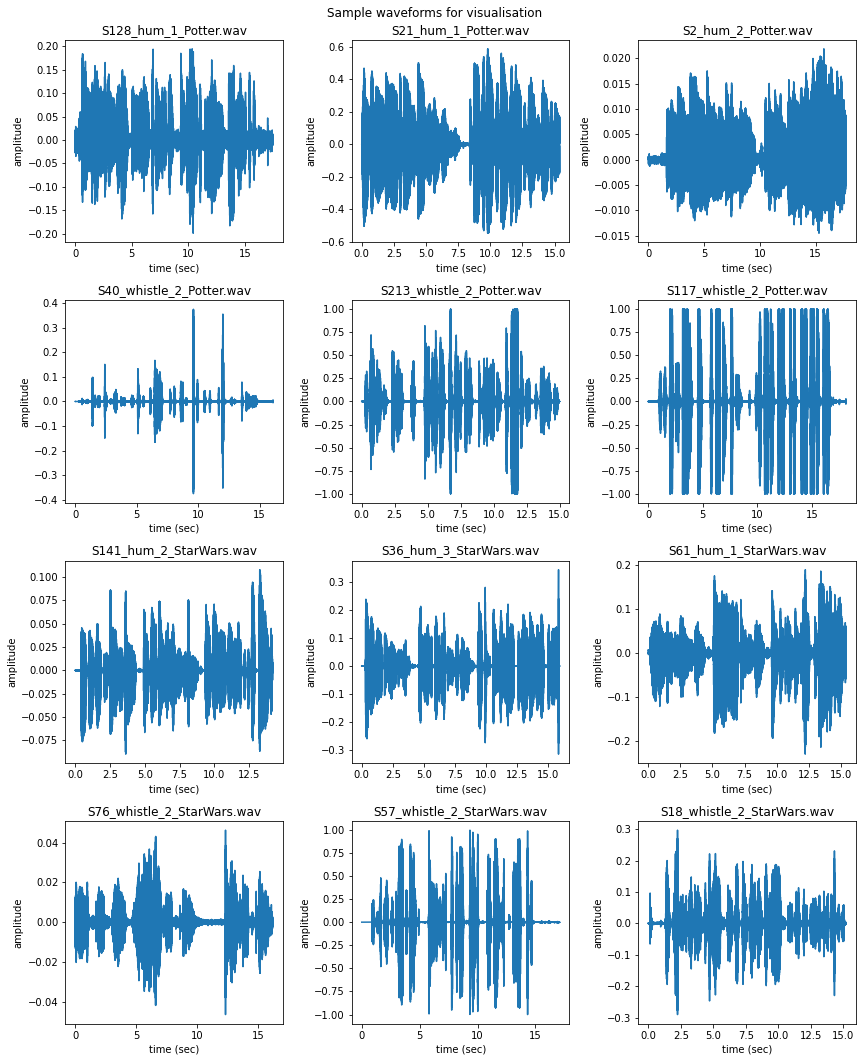

In [33]:
#get samples - 12 in total - 3 hums an3 whistles for potter and star wars each
sample_hw = potter_wars_df.groupby(['song', 'interpretation'])['location'].apply(lambda s: s.sample(3))
#create file list for samples above
sample_hw_list = [list(sample_hw.values.flatten())[i] + sample_hw.index[i][2] for i in range(len(sample_hw.index))]
#plot audio waveforms
fig, axes = plt.subplots(4,3,figsize = (12,15))
sr = 44100
for i, ax in enumerate(axes.flatten()):
    # Sampling frequency. If None, fs would be 22050
    x, sr = librosa.load(sample_hw_list[i],sr=sr)
    t = np.arange(len(x))/sr
    ax.plot(t,x)
    ax.set_xlabel('time (sec)')
    ax.set_ylabel('amplitude')
    ax.set_title(sample_hw_list[i].split('/')[-1])
fig.suptitle('Sample waveforms for visualisation')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

We can see that the original waveforms above are quite different from one another and no meaningful pattern can be derived at a glance.

Since the features (pitch contours) are going to be defined per frame, the audio files need to be of a consistent length to get the same number of frames. Any silence (useless information) in the beginning of all audio files is removed and 15 sec of audio from the onset of first sound is saved:

In [18]:
# carry out the pre-processing - remove silence, and trim/pad the signals

#get first instance where audio file is not silent. Then get the next 15 seconds (for sample rate of 44100/sec, 15 sec = 661500 samples)
def trim_audio(audio_waveform, sr=44100, length = 15, silence_db = 20):
    """Takes an audio waveform (array/list) of sample rate sr, removes silence from the beginning of the file, and gets the next 15sec. 
    Pads zeros to the right if start of non silent portion + 15 sec is greater than the original length of the file. 
    Returns trimmed waveform data."""
    start_sample = librosa.effects.split(audio_waveform, top_db = silence_db)[0][0] #the first sample where there is no silence
    if len(audio_waveform) < start_sample + (length * sr):
        trimmed_wave = audio_waveform[start_sample:]
        trimmed_wave = librosa.util.fix_length(trimmed_wave,length*sr)
    else:
        trimmed_wave = audio_waveform[start_sample:start_sample+(length*sr)]
    return trimmed_wave

In [19]:
#get the trimmed waves
trimmed_waves = [trim_audio(wave, sr = 44100, length = 15, silence_db= 20) for wave in waveforms]
trimmed_waves = np.asarray(trimmed_waves)
trimmed_waves.shape

(834, 661500)

We see that the trimmed waves array has 834 data points (recordings) with each data point consisting of 661500 samples. Visualising these trimmed waveforms using the same samples used above:

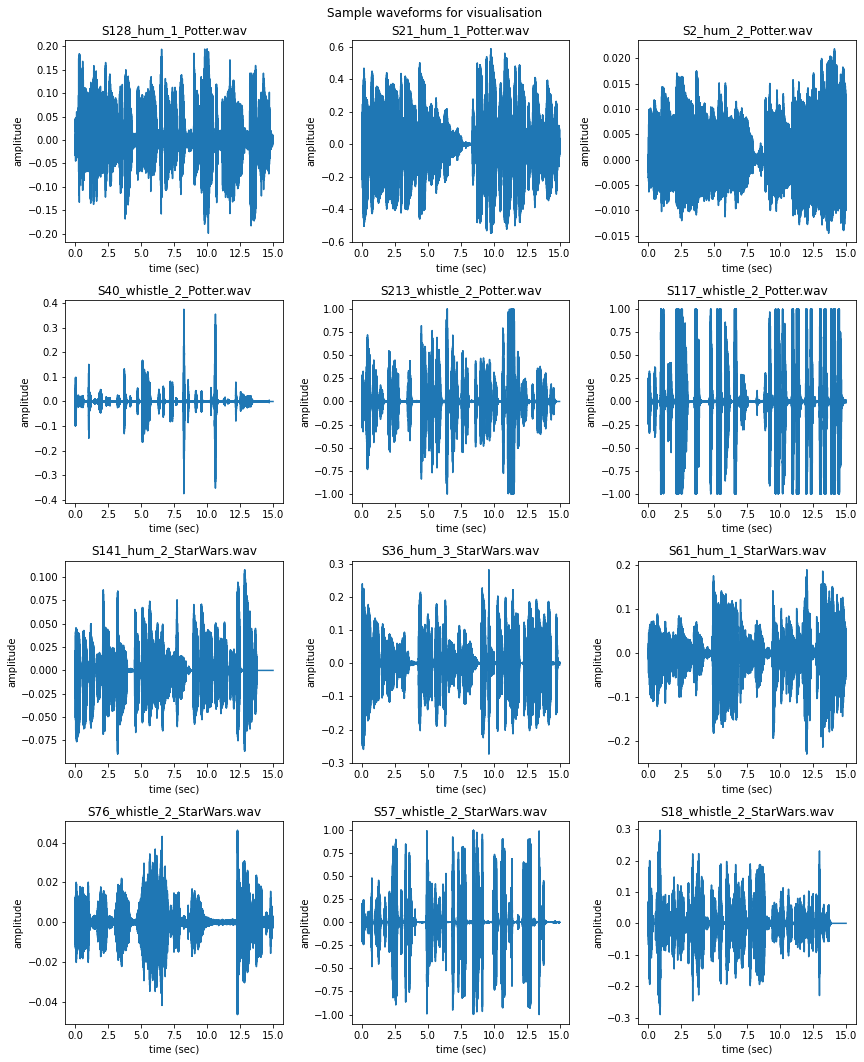

In [35]:
#plot audio waveforms
fig, axes = plt.subplots(4,3,figsize = (12,15))
sr = 44100
for i, ax in enumerate(axes.flatten()):
    # Sampling frequency. If None, fs would be 22050
    x, sr = librosa.load(sample_hw_list[i],sr=sr)
    trim = trim_audio(x)
    t = np.arange(len(trim))/sr
    ax.plot(t,trim)
    ax.set_xlabel('time (sec)')
    ax.set_ylabel('amplitude')
    ax.set_title(sample_hw_list[i].split('/')[-1])
fig.suptitle('Sample waveforms for visualisation')
fig.tight_layout()
fig.subplots_adjust(top=0.95)


Comparing the above to the original, it can be seen that the waveforms have been succesfully trimmed at the beginning and the length has been made consistent to 15 sec.

## 7.2 Feature exploration/ extraction

For simplicity and conciseness, only the pitch contours features will be extracted and explored here. Experimentation and visualisations of other features that were evaluated are included in the appendix (for interest only).

Reference to paper that inspired the use of pitch contours as a possible solution: https://www.mdpi.com/2076-3417/8/4/507/htm

Extracting the pitch contours for all waveforms:

In [36]:
#Extract pitch (f0) for all data
n_fft = 8192 #8192 frame length equates to ~186ms per frame. 4410 equates to 100ms.
def get_pitch(audio_waveform, frame_length = 8192, sr = 44100, fmin =65, fmax = 2093):
    f0, vf, vb = librosa.pyin(y=audio_waveform, sr=sr, fmin = fmin, fmax = fmax, frame_length=frame_length,hop_length=frame_length//2)
    return f0

f0 = [get_pitch(wave) for wave in trimmed_waves]
f0 = np.vstack(f0)
#important to carry this out - replaces NaNs with 0s
np.nan_to_num(f0,copy = False)
display(f0.shape)

(834, 162)

Thus, our data consists of 834 samples and 162 features.

Visualising the pitch contours superimposed on a spectogram (visual depiction of a frequency spectrum over time) for a random song:

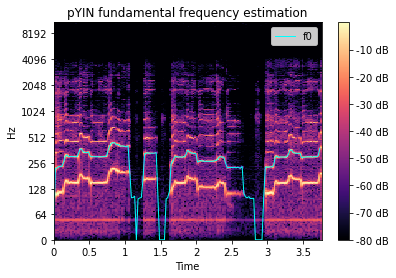

In [37]:
#plot spectogram and overlay with fundamental frequency envelope
D = librosa.amplitude_to_db(np.abs(librosa.stft(trimmed_waves[24], n_fft = 8192, hop_length = 8192//2)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
times = librosa.times_like(f0[24])
ax.plot(times, f0[24], label='f0', color='cyan', linewidth=1)
ax.legend(loc='upper right')

The above shows that the underlying 'melody' of the song is captured well by the fundamental frequencies. Note that fundamental frequency extraction can result in Nan values. These need to be replaced. As shown above, the sudden dips to 0 are because the nan values were replaced with 0. 

The above features can now be used to train different models for classification purposes. However, since multiple models will be evaluated, the data needs to be split between training and testing:

In [85]:
#get y labels and split data (70%-30%):
y = (potter_wars_df.song=='Potter').astype('int') #true for potter, false for starwars
y = y.values

#training and test split f0 and y
X_train, X_test, y_train, y_test = train_test_split(f0,y,test_size=0.3)

print("Shapes: X_train: {}; y_train: {}; X_test: {}; y_test: {}".format(X_train.shape,y_train.shape,X_test.shape,y_test.shape))

Shapes: X_train: (583, 162); y_train: (583,); X_test: (251, 162); y_test: (251,)


# 8 Results

In this section, the training data will be used for cross validation of the above mentioned models to obtain the best tuned model for each family (using the best mean cross validation accuracy score). The test data will be used to test the best tuned models from each family. The test accuracy score will be used to determine the best model for the pipeline. 

## 8.1 Using hyperparameter optimisation and cross fold validation:

### kNN:

10 fold cross validation and grid search is used to exhaustively search all the parameters in a defined search space and return the best tuned model.

In [86]:
# no. of k-neighbours to consider
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 30, num = 30)]
# weighting type
weights = ['uniform', 'distance']
#algorithm to use
algorithm = ['auto', 'ball_tree', 'kd_tree']
# leaf size for ball tree or kd tree algorithms
leaf_size = [int(x) for x in np.linspace(start = 10, stop = 50, num = 10)]
#create grid
grid = {'n_neighbors': n_neighbors,
               'weights': weights,
               'algorithm': algorithm,
               'leaf_size': leaf_size}

knn = neighbors.KNeighborsClassifier()
knn_grid = GridSearchCV(estimator = knn, param_grid = grid, cv = 10, verbose = 1, n_jobs = -1, return_train_score= True)
knn_grid.fit(X_train, y_train)

Fitting 10 folds for each of 1800 candidates, totalling 18000 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                         'leaf_size': [10, 14, 18, 23, 27, 32, 36, 41, 45, 50],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, verbose=1)

In [87]:
best_grid = knn_grid.best_estimator_ #select the best estimator
mean_train_accuracy = knn_grid.cv_results_["mean_train_score"][knn_grid.best_index_] #mean training accuracy for best model
mean_val_accuracy = knn_grid.cv_results_["mean_test_score"][knn_grid.best_index_] #mean cross validated accuracy for best model
y_pred_val = best_grid.predict(X_test) #keep prediction values for y
test_accuracy = best_grid.score(X_test,y_test) #test accuracy on test data
print('Mean training score for the best estimator: ', mean_train_accuracy)
print('Mean cross validated score for the best estimator: ', mean_val_accuracy)
print("Test accuracy (test dataset) using best model: {}".format(test_accuracy))
print("Best model's parameters: ", knn_grid.best_params_)

Mean training score for the best estimator:  0.92471973827699
Mean cross validated score for the best estimator:  0.8663062536528345
Test accuracy (test dataset) using best model: 0.8565737051792829
Best model's parameters:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 4, 'weights': 'uniform'}


The best tuned model for kNN has a cross validation accuracy of ~86.6% with a mean training accuracy of ~92.5%. This indicates that the model has not been overfit or underfit, and is very good at estimating unseen data. This is confirmed by the test accuracy score of 85.7% (on 30% of the original data that was not seen by the algorithm).

### Random Forest:

Randomised search cross validation is used first as grid search is an exhaustive search and computationally expensive for Random Forests. Once randomised search has finished and pointed towards a more focussed area, grid search cross validation will be used for further optimisation. [This article](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) was used to come up with this method.

In [92]:
# Randomised Search - Cross validation
# define search space for randomised_search_cv

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 20, num = 10)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 20, num = 10)]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 10, verbose = 1, n_jobs=-1, return_train_score= True) #perform 10 fold cross validation
rf_random.fit(X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 5, 7, 9, 11,
                                                             13, 15, 17, 20],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14, 16, 18,
                                                              20],
                                        'n_estimators': [50, 89, 129, 169, 209,
                                                         248, 288, 328, 368,
  

In [93]:
best_random = rf_random.best_estimator_ #select best estimator
mean_train_accuracy = rf_random.cv_results_["mean_train_score"][rf_random.best_index_] #mean training accuracy for best model
mean_val_accuracy = rf_random.cv_results_["mean_test_score"][rf_random.best_index_] #mean cross validated accuracy for best model
y_pred_val = best_random.predict(X_test) #keep prediction values for y
test_accuracy = best_random.score(X_test,y_test)
print('Mean training score for the best estimator: ', mean_train_accuracy)
print('Mean cross validated score for the best estimator: ', mean_val_accuracy)
print("Test accuracy (test dataset) using best model: {}".format(test_accuracy))
print("Best model's parameters: ", rf_random.best_params_)

Mean training score for the best estimator:  0.9990468920392586
Mean cross validated score for the best estimator:  0.8818527177089421
Test accuracy (test dataset) using best model: 0.8844621513944223
Best model's parameters:  {'n_estimators': 1044, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}


From the above, the test accuracy (on 30% of the original data that was not seen by the algorithm) using the best tuned model is 88.4%. This is very close to the mean cross validated score for the best tuned model (88.1%) and as such is very good. However, the mean training score is 99.9% indicating overfitting. The results of the best parameter from the above will be used to perform a focussed exhaustive grid search to see if the model can be improved. n_estimators will be increased, and max depth will be reduced to reduce the risk of overfitting.

In [94]:
# Number of trees in random forest
n_estimators = [1044, 1200, 1400, 1600]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [20,30,40,50]
# Minimum number of samples required to split a node
min_samples_split = [7,8,9]
# Minimum number of samples required at each leaf node
min_samples_leaf = [3,4,5]
# Method of selecting samples for training each tree
bootstrap = [True]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 10, verbose = 1, n_jobs=-1, return_train_score= True)
rf_grid.fit(X_train, y_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [20, 30, 40, 50],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [7, 8, 9],
                         'n_estimators': [1044, 1200, 1400, 1600]},
             return_train_score=True, verbose=1)

In [96]:
best_grid = rf_grid.best_estimator_
mean_train_accuracy = rf_grid.cv_results_["mean_train_score"][rf_grid.best_index_] #mean training accuracy for best model
mean_val_accuracy = rf_grid.cv_results_["mean_test_score"][rf_grid.best_index_] #mean cross validated accuracy for best model
y_pred_val = best_grid.predict(X_test) #keep prediction values for y
test_accuracy = best_grid.score(X_test,y_test)
print('Mean training score for the best estimator: ', mean_train_accuracy)
print('Mean cross validated score for the best estimator: ', mean_val_accuracy)
print("Test accuracy (test dataset) using best model: {}".format(test_accuracy))
print("Best model's parameters: ", rf_grid.best_params_)

Mean training score for the best estimator:  0.9979040348964014
Mean cross validated score for the best estimator:  0.8853302162478082
Test accuracy (test dataset) using best model: 0.8844621513944223
Best model's parameters:  {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 1200}


From above, it can be seen that there hasn't been much improvement. The test accuracy has not changed but the mean validation score for the best tuned model has improved slightly by around 0.3%. Training accuracy has gone down very slightly to 99.8%. 

Although, there is still evidence of overfitting, the model has a high validation accuracy, and performs better on test data than the kNN model. 

Thus the model that will be part of the final pipeline:

In [104]:
rf_model_chosen = rf_grid.best_estimator_#choose the optimised model found by grid search
rf_model_chosen.get_params #display the parameters for the best model

<bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=9, n_estimators=1200)>

Defining a pipeline function using the above features and model to predict an audio recording as potter or starwars:

In [130]:
def pipeline(audio_path_list, model = rf_model_chosen):
    """using the chosen model, predict the label for an audio located in the path in the audio_path_list (list)"""
    waveform, fs = get_waveforms(audio_path_list) #get waveforms
    trimmed_wave = [trim_audio(wave, sr = 44100, length = 15, silence_db= 20) for wave in waveform] #trim waveform
    trimmed_wave = np.asarray(trimmed_wave)
    f0 = [get_pitch(wave) for wave in trimmed_wave] #extract pitch contours
    f0 = np.vstack(f0)
    #important to carry this out - replaces NaNs with 0s
    np.nan_to_num(f0,copy = False)
    class_label = model.predict(f0) #use the chosen model to predict
    return class_label #1 for potter, 0 for starwars


# 9 Conclusions

A machine learning pipeline solving a binary classification problem of differentiating between the Harry Potter theme song and the Star Wars theme song has been proposed in this notebook. The machine learning model recommended in the pipeline has a test accuracy of almost 90% and can thus be considered a success. Multiple features were explored but pitch contours (or fundamental frequency) was found to be the most effective. Feature extraction was the most crucial aspect of the methodology to obtain high accuracies. The learnings from this notebook can be transferred to the advanced solution where a multi-class problem will be solved.

Drawbacks:
- The major drawback of an implementation using pitch contours as features is that if a user records a hum or a whistle that is too slow or too fast, the classifier won't be able to classify the song correctly as the fundamental frequencies will be at very different positions in the feature vector from the rest of the data. One would hope that the training data is representative and this has been accounted for but with only 834 recordings and a controlled environment (participants were students told to keep the recordings around a certain length), it is unlikely. 
- Pitch contours have performed really well for two songs but may not scale well with more songs. The more songs there are the higher the likelihood that there will be multiple frames of different songs that have the same/ similar fundamental frequency (for a given time). 

Recommended improvements:
- Carry out an outlier analysis on the actual audio data. If there are 'prank' recordings or files with unrecognisable audio, they should be discarded. This was not carried out in this project.
- When extracting pitch contours, experiment with replacing Nan values with mean or interpolated values instead of 0 to see if that makes a difference.
- Experiment with implementation of a convolutional neural network using mel spectograms or MFCCs as the combination is considered the best way to extract useful features from audio signals according to research.
- Experiment with time series classifiers such as kNN with DTW (dynamic time warping) or Time series forest or Random Interval Spectral Ensemble that treat the data as a time series and preserve the sequence in which the features occur. This might help counter the drawbacks mentioned above.

# 10 Appendix - For interest only

The contents in this section were copied from other notebooks and have not been run in this notebook. Only included here for completeness and to prove that a lot of research and experimentation was carried out that couldn't be included in the main body. The wording has not been refined as well and there may be mistakes.

## 10.1 Feature exploration/ extraction experimentation

To distinguish between melodies, we need to be able to extract the features that define a melody. For example changes in frequency for every subsequent time frame, or onsets and their strengths in each frame. We will try a few different inputs:
1. Onset strength/time
2. Spectral centroid
3. Spectral rolloff
4. Mel spectogram
5. Original features of power, pitch mean, pitch standard deviation, voiced fraction from the starter kit

### 10.1.1 Onset strength/detection

In [ ]:
#Extract onset strength for all data
n_fft = 8192 #8192 frame length equates to ~186ms per frame. 4410 equates to 100ms.
def get_onset_str(audio_waveform, frame_length = 8192, sr = 44100, agg = np.median):
    return librosa.onset.onset_strength(y= audio_waveform, sr=sr, aggregate=agg, n_fft = frame_length, hop_length = frame_length//2)


In [ ]:
onsets = [get_onset_str(wave) for wave in trimmed_waves]
onsets = np.asarray(onsets)
onsets.shape
# np.save('onsets', onsets)

(834, 162)

#### lets try and fit kNN and random forests with just onsets:

#### split data, get labels

In [ ]:
#get y labels
y = (potter_wars_df.song=='Potter').astype('int') #true for potter, false for starwars
y = y.values

In [ ]:
#train, test split onsets
X_train, X_val, y_train, y_val = train_test_split(onsets,y,test_size=0.3)
# X_train_val, X_val, y_train_val, y_val = train_test_split(X_train,y_train,test_size=0.25)

#### Using hyperparameter optimisation and cross fold validation:

#### Random Forest:

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 20, num = 10)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 20, num = 10)]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 5, verbose = 2, n_jobs=-1)
rf_random.fit(X_train, y_train)
best_random = rf_random.best_estimator_
train_accuracy = best_random.score(X_train, y_train)
val_accuracy = best_random.score(X_val,y_val)
print(train_accuracy, val_accuracy)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
1.0 0.8167330677290837


In [ ]:
rf_random.best_params_

{'n_estimators': 1124,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': False}

In [ ]:
# Number of trees in random forest
n_estimators = [1000, 1100, 1200]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [40]
# Minimum number of samples required to split a node
min_samples_split = [4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 5, verbose = 2, n_jobs=-1)
rf_random.fit(X_train, y_train)
best_random = rf_random.best_estimator_
train_accuracy = best_random.score(X_train, y_train)
val_accuracy = best_random.score(X_val,y_val)
print(train_accuracy, val_accuracy)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
1.0 0.8127490039840638


In [ ]:
rf_random.best_estimator_

RandomForestClassifier(max_depth=40, max_features='sqrt', min_samples_split=4,
                       n_estimators=1200)

#### kNN:

In [ ]:
# no. of k-neighbours to consider
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 30, num = 30)]
# weighting type
weights = ['uniform', 'distance']
#algorithm to use
algorithm = ['auto', 'ball_tree', 'kd_tree']
# leaf size for ball tree or kd tree algorithms
leaf_size = [int(x) for x in np.linspace(start = 10, stop = 50, num = 10)]
#create grid
grid = {'n_neighbors': n_neighbors,
               'weights': weights,
               'algorithm': algorithm,
               'leaf_size': leaf_size}

knn = neighbors.KNeighborsClassifier()
knn_grid = GridSearchCV(estimator = knn, param_grid = grid, cv = 5, verbose = 2, n_jobs = -1)
knn_grid.fit(X_train, y_train)
best_grid = knn_grid.best_estimator_
train_accuracy = best_grid.score(X_train, y_train)
val_accuracy = best_grid.score(X_val,y_val)
print(train_accuracy, val_accuracy)
print(best_grid.get_params())

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
0.8421955403087479 0.7729083665338645
{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}


#### We see that onsets work really well and we get validation accuracy of 81.2% and 77.3% from RF and kNN respectively after performing cross validation.

### 10.1.2 Spectral centroids

In [ ]:
#Extract spectral centroids for data
n_fft = 8192 #8192 frame length equates to ~186ms per frame. 4410 equates to 100ms.
def get_spec_cent(audio_waveform, sr = 44100, frame_length = 8192):
    return librosa.feature.spectral_centroid(y= audio_waveform, sr=sr, n_fft = frame_length, hop_length = frame_length//2)

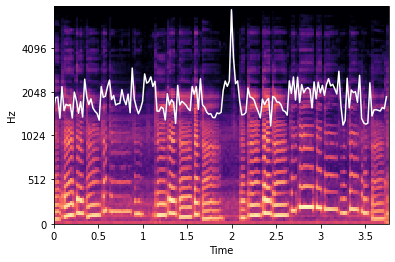

In [ ]:
fig,ax = plt.subplots()
cent = get_spec_cent(trimmed_waves[0])
times = librosa.times_like(cent)
mel_0 = librosa.feature.melspectrogram(y=trimmed_waves[0], sr=44100, n_fft = 8192, hop_length = 8192//2)
librosa.display.specshow(librosa.power_to_db(mel_0, ref=np.max), y_axis='mel', fmax=8000, x_axis='time', ax=ax)
ax.plot(times, cent.T, label='Spectral centroid', color='w')

In [ ]:
cents = [get_spec_cent(wave) for wave in trimmed_waves]
cents = np.vstack(cents)
cents.shape

(834, 162)

#### split data, get labels and do basic knn

In [ ]:
#get y labels
y = (potter_wars_df.song=='Potter').astype('int') #true for potter, false for starwars
y = y.values

In [ ]:
#train, test split spectral centroids
X_train, X_val, y_train, y_val = train_test_split(cents,y,test_size=0.3)
# X_train_val, X_val, y_train_val, y_val = train_test_split(X_train,y_train,test_size=0.25)

#### Using hyperparameter optimisation and cross fold validation:

#### Random Forest:

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 20, num = 10)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 20, num = 10)]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 5, verbose = 2, n_jobs=-1)
rf_random.fit(X_train, y_train)
best_random = rf_random.best_estimator_
train_accuracy = best_random.score(X_train, y_train)
val_accuracy = best_random.score(X_val,y_val)
print(train_accuracy, val_accuracy)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
1.0 0.796812749003984


In [ ]:
rf_random.best_params_

{'n_estimators': 1880,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [ ]:
# Number of trees in random forest
n_estimators = [1800, 1900, 2000]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [None]
# Minimum number of samples required to split a node
min_samples_split = [4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,3]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 5, verbose = 2, n_jobs=-1)
rf_random.fit(X_train, y_train)
best_random = rf_random.best_estimator_
train_accuracy = best_random.score(X_train, y_train)
val_accuracy = best_random.score(X_val,y_val)
print(train_accuracy, val_accuracy)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
1.0 0.7928286852589641


In [ ]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=4, n_estimators=1800)

#### kNN:

In [ ]:
# no. of k-neighbours to consider
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 30, num = 30)]
# weighting type
weights = ['uniform', 'distance']
#algorithm to use
algorithm = ['auto', 'ball_tree', 'kd_tree']
# leaf size for ball tree or kd tree algorithms
leaf_size = [int(x) for x in np.linspace(start = 10, stop = 50, num = 10)]
#create grid
grid = {'n_neighbors': n_neighbors,
               'weights': weights,
               'algorithm': algorithm,
               'leaf_size': leaf_size}

knn = neighbors.KNeighborsClassifier()
knn_grid = GridSearchCV(estimator = knn, param_grid = grid, cv = 5, verbose = 2, n_jobs = -1)
knn_grid.fit(X_train, y_train)
best_grid = knn_grid.best_estimator_
train_accuracy = best_grid.score(X_train, y_train)
val_accuracy = best_grid.score(X_val,y_val)
print(train_accuracy, val_accuracy)
print(best_grid.get_params())

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
1.0 0.7250996015936255
{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 28, 'p': 2, 'weights': 'distance'}


#### We get 79 and 72% for RF and KNN respectively using spectral centroids

### 10.1.3 Spectral roll-off minimum frequency

In [ ]:
#Extract roll off min frequency for all data
n_fft = 8192 #8192 frame length equates to ~186ms per frame. 4410 equates to 100ms.
def get_rolloff(audio_waveform, frame_length = 8192, sr = 44100, roll_percent = 0.01):
    return librosa.feature.spectral_rolloff(y= audio_waveform, sr=sr, roll_percent=roll_percent, n_fft = frame_length, hop_length = frame_length//2)


In [ ]:
spec_rolloff = [get_rolloff(wave) for wave in trimmed_waves]
spec_rolloff = np.vstack(spec_rolloff)
spec_rolloff.shape

(834, 162)

#### lets try and fit kNN and random forests with spec rolloff:

#### split data, get labels and do basic knn

In [ ]:
#get y labels
y = (potter_wars_df.song=='Potter').astype('int') #true for potter, false for starwars
y = y.values

In [ ]:
#train, test split onsets
X_train, X_val, y_train, y_val = train_test_split(spec_rolloff,y,test_size=0.3)
# X_train_val, X_val, y_train_val, y_val = train_test_split(X_train,y_train,test_size=0.25)

#### Using hyperparameter optimisation and cross fold validation:

#### Random Forest:

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 20, num = 10)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 20, num = 10)]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 5, verbose = 2, n_jobs=-1)
rf_random.fit(X_train, y_train)
best_random = rf_random.best_estimator_
train_accuracy = best_random.score(X_train, y_train)
val_accuracy = best_random.score(X_val,y_val)
print(train_accuracy, val_accuracy)
print('Mean cross validation score: ', rf_random.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
0.9965694682675815 0.7569721115537849
Mean cross validation score:  0.7392425582080755


In [ ]:
rf_random.best_params_

{'n_estimators': 1920,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': False}

In [ ]:
# Number of trees in random forest
n_estimators = [1800, 1900, 2000]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [50,60]
# Minimum number of samples required to split a node
min_samples_split = [2,3]
# Minimum number of samples required at each leaf node
min_samples_leaf = [3]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 5, verbose = 2, n_jobs=-1)
rf_random.fit(X_train, y_train)
best_random = rf_random.best_estimator_
train_accuracy = best_random.score(X_train, y_train)
val_accuracy = best_random.score(X_val,y_val)
print(train_accuracy, val_accuracy)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.9965694682675815 0.7370517928286853


In [ ]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=60, min_samples_leaf=3,
                       min_samples_split=3, n_estimators=1900)

#### kNN:

In [ ]:
# no. of k-neighbours to consider
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 30, num = 30)]
# weighting type
weights = ['uniform', 'distance']
#algorithm to use
algorithm = ['auto', 'ball_tree', 'kd_tree']
# leaf size for ball tree or kd tree algorithms
leaf_size = [int(x) for x in np.linspace(start = 10, stop = 50, num = 10)]
#create grid
grid = {'n_neighbors': n_neighbors,
               'weights': weights,
               'algorithm': algorithm,
               'leaf_size': leaf_size}

knn = neighbors.KNeighborsClassifier()
knn_grid = GridSearchCV(estimator = knn, param_grid = grid, cv = 5, verbose = 2, n_jobs = -1)
knn_grid.fit(X_train, y_train)
best_grid = knn_grid.best_estimator_
train_accuracy = best_grid.score(X_train, y_train)
val_accuracy = best_grid.score(X_val,y_val)
print(train_accuracy, val_accuracy)
print(best_grid.get_params())

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
0.9982847341337907 0.649402390438247
{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 4, 'p': 2, 'weights': 'distance'}


#### Not great - discard spectral roll offs (73 and 65 for RF and kNN)

### 10.1.4 Mel Frequency Spectograms

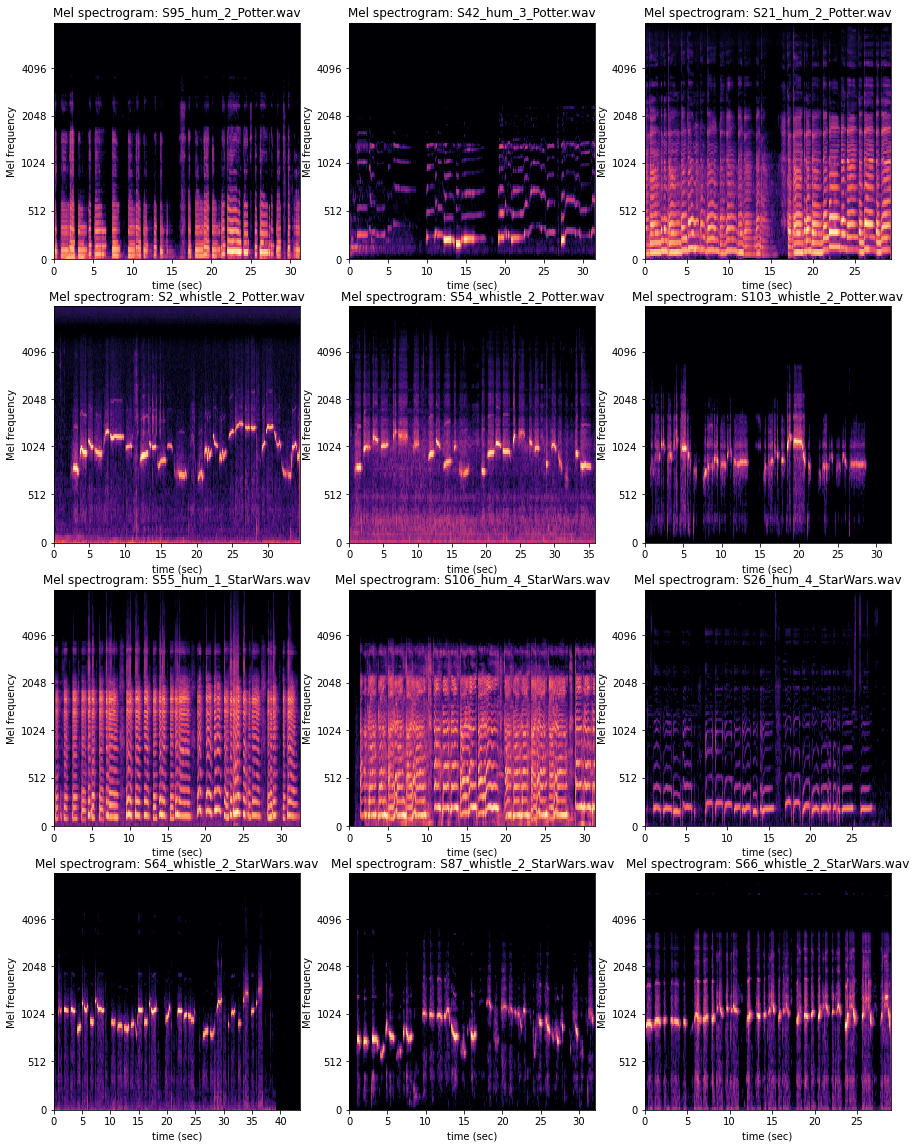

In [ ]:
#plot mel spectrograms
import librosa.display
fig, axes = plt.subplots(4,3,figsize = (15,20))
fs = None
for i, ax in enumerate(axes.flatten()):
    # Sampling frequency. If None, fs would be 22050
    x, fs = librosa.load(sample_hw_list[i],sr=fs)
    S = librosa.feature.melspectrogram(y=x, sr=fs)
    im = librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', fmax=8000, x_axis='time', ax=ax)
    #ax.colorbar(format='%+2.0f dB')
    ax.set_title('Mel spectrogram: '+ sample_hw_list[i].split('/')[-1])
    ax.set_xlabel('time (sec)')
    ax.set_ylabel('Mel frequency')

The above returns 128 mels over a period of time for each audio input

In [ ]:
from skimage.io import imread, imshow, imsave
from skimage.filters import prewitt_h,prewitt_v
from sklearn.preprocessing import MinMaxScaler

In [ ]:
min_max = MinMaxScaler((0,255))
# S = np.log(S + 1e-9)
img = min_max.fit_transform(S).astype(np.uint8)
img = np.flip(img, axis=0) # put low frequencies at the bottom in image
img = 255-img # invert. make black==more energy

# save as PNG
imsave('test_img2.png', img)



In [ ]:
image = imread('test_img.png',as_gray=True)

#calculating horizontal edges using prewitt kernel
edges_prewitt_horizontal = prewitt_h(image)
#calculating vertical edges using prewitt kernel
edges_prewitt_vertical = prewitt_v(image)

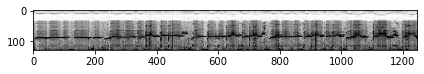

In [ ]:
imshow(image)
# imshow(edges_prewitt_horizontal, cmap='gray')

In [ ]:
image.shape

(128, 1247)

The no. of features will be 128*1247 = 159616. We can either look at a smaller window, reduce the number of mels (bins) or use PCA for dimensionality reduction or do all of the above.

Trying with only PCA:

In [ ]:
def getXy_spec(files,labels_file, scale_audio=False, onlySingleDigit=False):
  min_max = MinMaxScaler((0,255))
  X_spec,y_spec =[],[]
  components = 4
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]

    yi = labels_file.loc[fileID]['song']=='Potter' #true for potter, false for starwars

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    S = librosa.feature.melspectrogram(y=x, sr=fs, n_mels = 40)
    
    # S = np.log(S + 1e-9)
    img = min_max.fit_transform(S).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy

    # save as PNG
    imsave('test_img.png', img)
    image = imread('test_img.png',as_gray=True)
    
    pca = PCA(n_components = components)
    pca.fit(image)
    projected = pca.transform(image)

    xi = list(projected.flatten())
    X_spec.append(xi)
    y_spec.append(yi)

  return np.array(X_spec),np.array(y_spec)

In [ ]:
X_spec, y_spec = getXy_spec(potter_wars_list,potter_wars_df)

100%|██████████| 420/420 [00:17<00:00, 23.66it/s]


In [ ]:
X_spec.shape

(420, 160)

In [ ]:
#train, test split hums
X_train, X_val, y_train, y_val = train_test_split(X_spec,y_spec,test_size=0.3)

In [ ]:
#SVM
model  = svm.SVC(C=1, gamma = 3)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 1.0
Validation  Accuracy 0.48412698412698413
The support vectors are (294, 160)


In [ ]:
#Random forest

rf = RandomForestClassifier(min_samples_leaf=0.2, max_features='auto', max_depth= 20)
rf.fit(X_train, y_train)
print('Training accuracy : {}'.format(rf.score(X_train, y_train)))
print('Validation accuracy : {}'.format(rf.score(X_val, y_val)))

Training accuracy : 0.673469387755102
Validation accuracy : 0.5396825396825397


In [ ]:
#Logistic regression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Training accuracy : {}'.format(logreg.score(X_train, y_train)))
print('Validation accuracy : {}'.format(logreg.score(X_val, y_val)))

Training accuracy : 0.8469387755102041
Validation accuracy : 0.5952380952380952


/Users/achalmittal/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


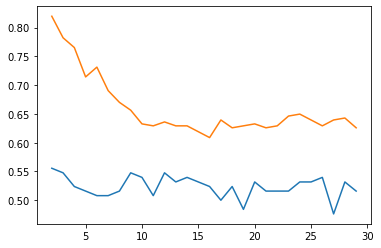

In [ ]:
k_values = range(2,30) #try k values from 1 to 20

accuracy_t = dict.fromkeys(k_values)
accuracy_v = dict.fromkeys(k_values)

for k in k_values:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # we calculate the validation accuracy
    y_val_pred = knn.predict(X_val)
    accuracy_v[k] = np.sum(y_val==y_val_pred)/len(y_val)

    # Training accuracy
    y_train_pred = knn.predict(X_train)
    accuracy_t[k] = np.sum(y_train==y_train_pred)/len(y_train)
plt.plot(accuracy_v.keys(), accuracy_v.values())
plt.plot(accuracy_t.keys(),accuracy_t.values())

### 10.1.5 Using features and code from the starter kit

We will use four audio features, namely:

1.   Power.
2.   Pitch mean.
3.   Pitch standard deviation.
4.   Fraction of voiced region.

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [ ]:
# create y labels cosisting of 1 for Potter, 0 for starwars.
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    #print(file_name)
    #print(labels_file.loc[fileID]['interpretation'])
    #print(labels_file.loc[fileID]['interpretation']=='hum')
    #yi = list(labels_file.loc[fileID]['interpretation'])[0]=='hum'
    yi = labels_file.loc[fileID]['song']=='Potter' #true for potter, false for starwars

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    xi = [power,pitch_mean,pitch_std,voiced_fr]
    X.append(xi)
    y.append(yi)

  return np.array(X),np.array(y)

In [ ]:
#Takes a long time: run only once and then save X and y into a file later
# X,y = getXy(potter_wars_list, labels_file=potter_wars_df, scale_audio=True, onlySingleDigit=True)

In [ ]:
#save X and y to files
# np.save('potter_wars_X_V0', X)
# np.save('potter_wars_y_V0', y)
#Load X and y
X = np.load('potter_wars_X_V0.npy')
y = np.load('potter_wars_y_V0.npy')

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

#### Analysing the extracted features

1d plotting:

In [ ]:
power = X[:,0]
pitch_mean = X[:,1]
pitch_std = X[:,2]
voiced_fr = X[:,3]
features = [power,pitch_mean,pitch_std,voiced_fr]

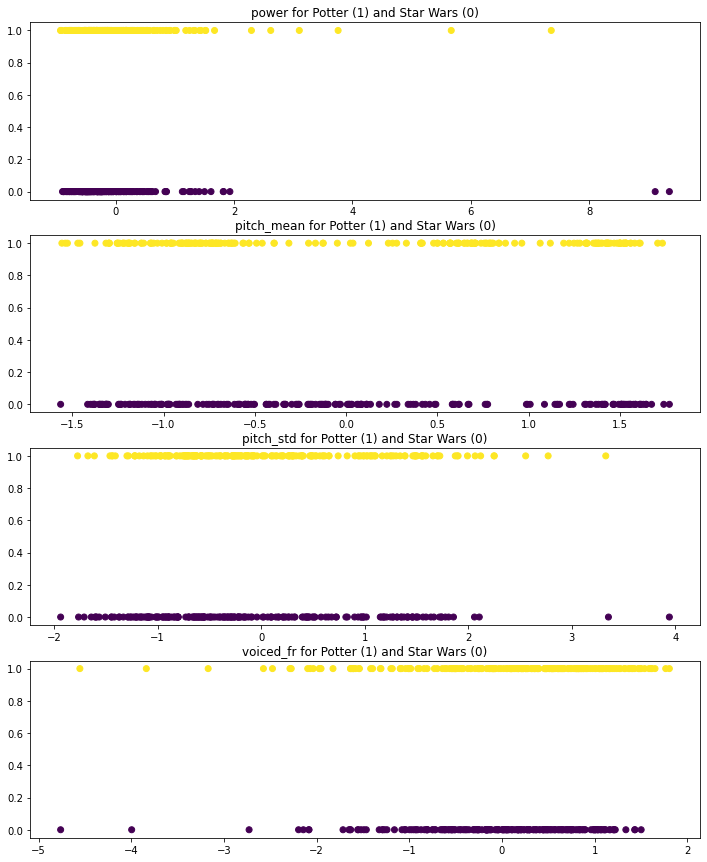

In [ ]:
labels = ['power', 'pitch_mean', 'pitch_std', 'voiced_fr']
fig, ax = plt.subplots(4,1, figsize = (12,15))

for i in range(4):
    ax[i].scatter(features[i],y, c = y)
    ax[i].set_title(labels[i]+ ' for Potter (1) and Star Wars (0)')

As we can see from above, there is considerable overlap between the two classes for every predictor, and hence no one featutre is good at distinguishing between the two.

Trying all combinations of predictors in 2D:

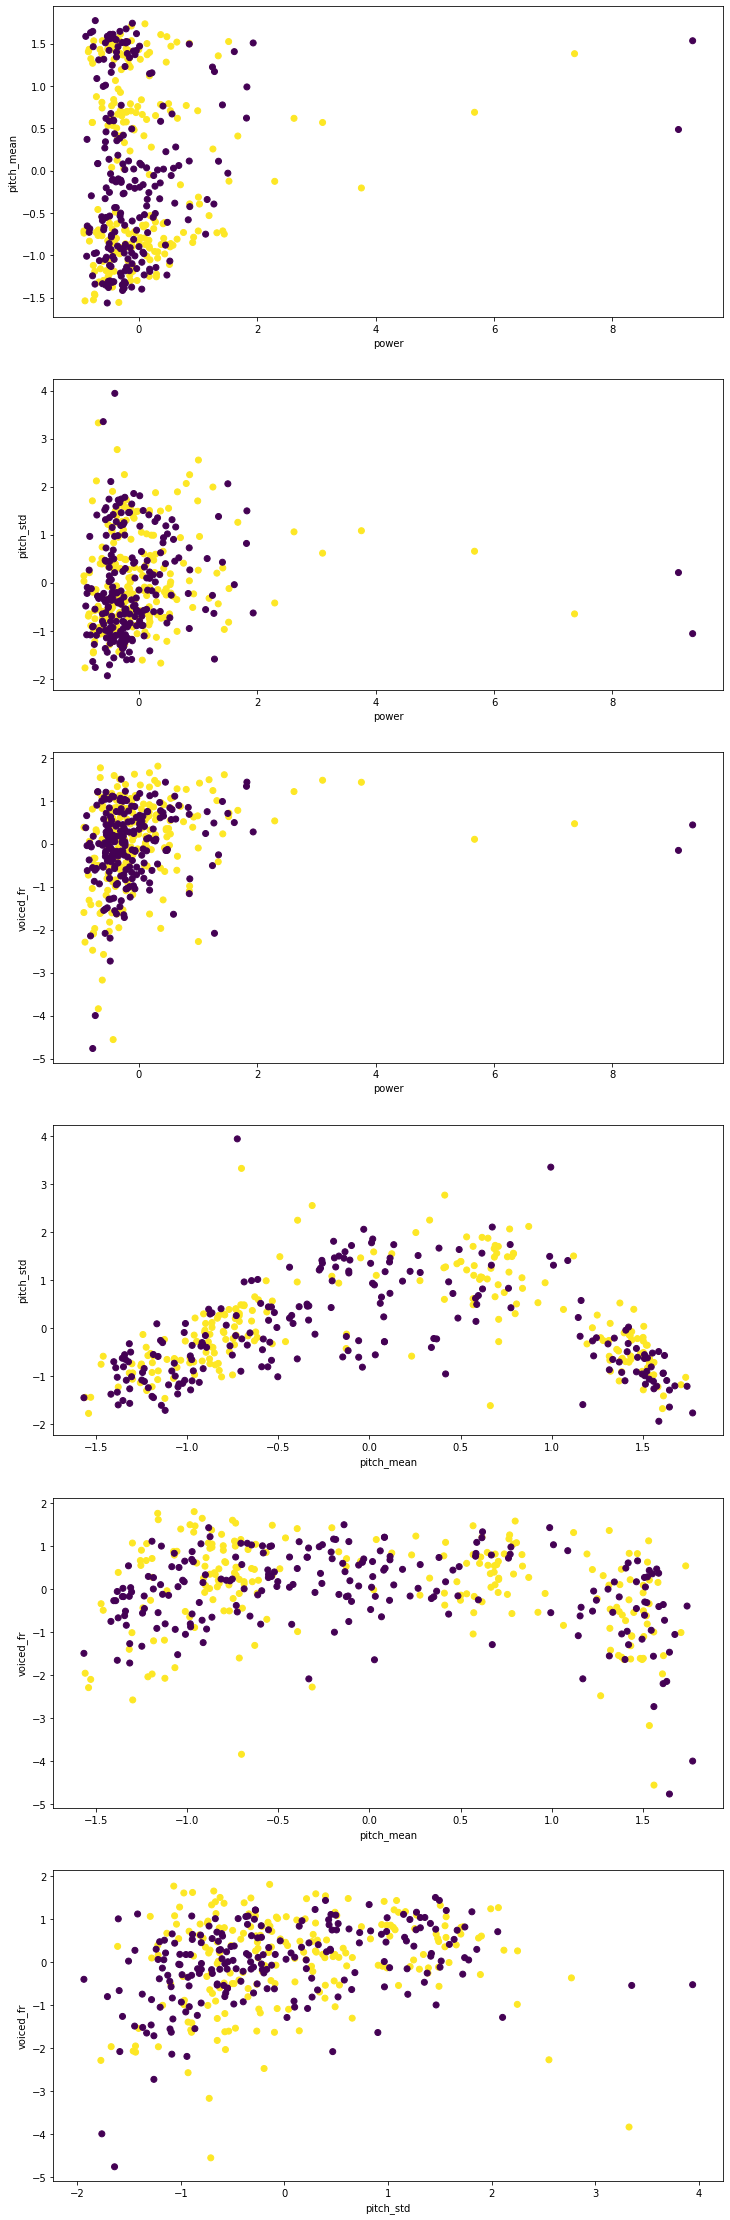

In [ ]:
import itertools

#generate combinations for 2d plotting
feature_combinations = [subset for subset in itertools.combinations(features, 2)]
label_combinations = [subset for subset in itertools.combinations(labels, 2)] 

fig, ax = plt.subplots(len(label_combinations),1, figsize = (12,40))
for i in range(0,len(label_combinations)):
  ax[i].scatter(feature_combinations[i][0], feature_combinations[i][1], c=y)
  ax[i].set_xlabel(label_combinations[i][0])
  ax[i].set_ylabel(label_combinations[i][1])
plt.show()

Again, we can't see any obvious patterns from the above plots that would allow us to separate the two classes using two predictors. 

Trying the same in 3d:

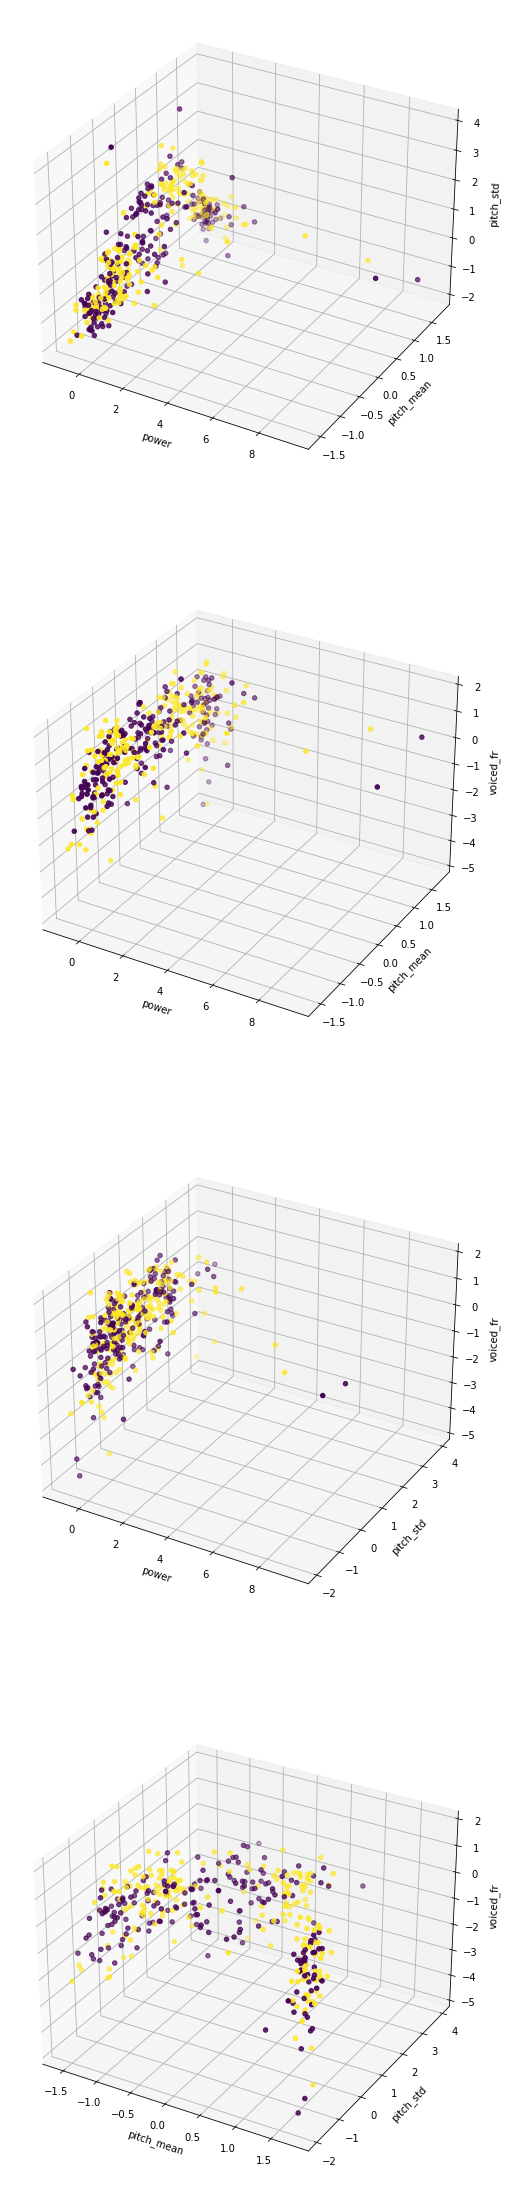

In [ ]:
#generate combinations for 3d plotting
feature_combinations = [subset for subset in itertools.combinations(features, 3)]
label_combinations = [subset for subset in itertools.combinations(labels, 3)] 

fig= plt.figure(figsize=(15,40))

for i in range(0,len(label_combinations)):
  ax = fig.add_subplot(len(label_combinations),1,i+1, projection = '3d')
  ax.scatter(feature_combinations[i][0], feature_combinations[i][1], feature_combinations[i][2], c=y)
  ax.set_xlabel(label_combinations[i][0])
  ax.set_ylabel(label_combinations[i][1])
  ax.set_zlabel(label_combinations[i][2])
plt.show()



Again, there are no obvious patterns that would allow us to separate the classes. However, from the last graph between pitch_mean, pitch_std, and voiced_fr, it can be deduced that a non-linear classifier such as KNN might perform well to distinguish between the classes. In the next step, we will implement KNN for these three predictors and for all 4 predictors combined and compare results:

#### Modeling: KNN

#### using 3 predictors 

In [ ]:
#split data into training and validation
from sklearn.model_selection import train_test_split
from sklearn import neighbors

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)

k_values = range(1,22,5) #try k values from 1 to 21 in steps of 5

accuracy_t = dict.fromkeys(k_values)
accuracy_v = dict.fromkeys(k_values)

for k in k_values:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train[:,1:], y_train)

    # we calculate the validation accuracy
    y_val_pred = knn.predict(X_val[:,1:])
    accuracy_v[k] = np.sum(y_val==y_val_pred)/len(y_val)

    # Training accuracy
    y_train_pred = knn.predict(X_train[:,1:])
    accuracy_t[k] = np.sum(y_train==y_train_pred)/len(y_train)

    print("The training accuracy for k=", k, "is ", accuracy_t[k])
    print("The validation accuracy for k=", k, "is ", accuracy_v[k])

The training accuracy for k= 1 is  1.0
The validation accuracy for k= 1 is  0.6111111111111112
The training accuracy for k= 6 is  0.7142857142857143
The validation accuracy for k= 6 is  0.5952380952380952
The training accuracy for k= 11 is  0.6938775510204082
The validation accuracy for k= 11 is  0.6825396825396826
The training accuracy for k= 16 is  0.6564625850340136
The validation accuracy for k= 16 is  0.6111111111111112
The training accuracy for k= 21 is  0.6054421768707483
The validation accuracy for k= 21 is  0.6190476190476191


The above was a good start (especially with k =11). Let's try with all 4 predictors:

In [ ]:
for k in k_values:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # we calculate the validation accuracy
    y_val_pred = knn.predict(X_val)
    accuracy_v[k] = np.sum(y_val==y_val_pred)/len(y_val)

    # Training accuracy
    y_train_pred = knn.predict(X_train)
    accuracy_t[k] = np.sum(y_train==y_train_pred)/len(y_train)

    print("The training accuracy for k=", k, "is ", accuracy_t[k])
    print("The validation accuracy for k=", k, "is ", accuracy_v[k])

The training accuracy for k= 1 is  1.0
The validation accuracy for k= 1 is  0.5952380952380952
The training accuracy for k= 6 is  0.6972789115646258
The validation accuracy for k= 6 is  0.6666666666666666
The training accuracy for k= 11 is  0.6972789115646258
The validation accuracy for k= 11 is  0.6111111111111112
The training accuracy for k= 16 is  0.6496598639455783
The validation accuracy for k= 16 is  0.5714285714285714
The training accuracy for k= 21 is  0.6020408163265306
The validation accuracy for k= 21 is  0.5714285714285714


#### Modeling: Support Vector Machines

Let's build a support vector machine (SVM) model:

Let's now fit an SVM model and print both the training accuracty and validation accuracy.


In [ ]:
from sklearn import svm
model  = svm.SVC(C=1, gamma = 2)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.8197278911564626
Validation  Accuracy 0.6507936507936508
The support vectors are (268, 4)


#### Bayes:

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

print('Training accuracy : {}'.format(gnb.score(X_train, y_train)))
print('Validation accuracy : {}'.format(gnb.score(X_val, y_val)))

Training accuracy : 0.5272108843537415
Validation accuracy : 0.4444444444444444


#### Random forest:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print('Training accuracy : {}'.format(rf.score(X_train, y_train)))
print('Validation accuracy : {}'.format(rf.score(X_val, y_val)))

Training accuracy : 1.0
Validation accuracy : 0.6904761904761905


#### Logistic regression:

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Training accuracy : {}'.format(logreg.score(X_train, y_train)))
print('Validation accuracy : {}'.format(logreg.score(X_val, y_val)))

Training accuracy : 0.5782312925170068
Validation accuracy : 0.5158730158730159


We can safely say that the features we have chosen to tackle the classification problem are not the best, and it is worth investigating others that might help with the classification.